In [1]:
import numpy as np
import scipy as sp
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
N = 100
mu_arr = np.array([1,10])
sigma_arr = np.array([1,1])
x = np.append(np.random.normal(mu_arr[0],sigma_arr[0],N),np.random.normal(mu_arr[1],sigma_arr[1],N))

<AxesSubplot:ylabel='Count'>

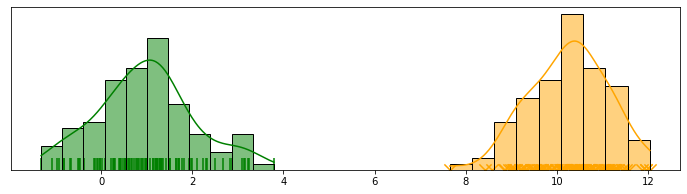

In [3]:
fig,ax = plt.subplots(figsize=(12,3))
ax.scatter(x[:N],np.zeros(N),c = 'green',marker=2,s=150)
ax.scatter(x[N:],np.zeros(N),c = 'orange',marker='x',s=150)
# ax.set_ylim([-1e-4, 1e-4])
_ = ax.set_yticks([])
sns.histplot(x[:N], color='green',kde=True)
sns.histplot(x[N:], color='orange',kde=True)

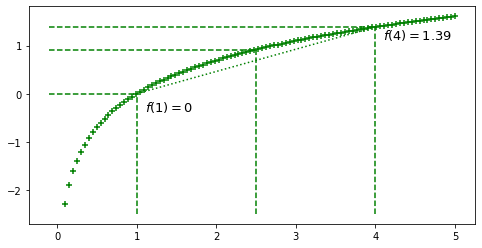

In [4]:
x = np.linspace(.1, 5, 100)
y = np.log(x)
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(x, y, color='green', marker='+')
## 1 (p=0.5)
ax.vlines(x=1, ymin=-2.5, ymax=0, linestyle='--', color='green')
ax.hlines(y=0, xmin=-.1, xmax=1, linestyle='--', color='green')
ax.text(x=1.1, y=np.log(.7), s='$f(1)=0$',
        fontdict={'size': 13})
## 4 (p=0.5)
ax.vlines(x=4, ymin=-2.5, ymax=np.log(4), linestyle='--', color='green')
ax.hlines(y=np.log(4), xmin=-.1, xmax=4, linestyle='--', color='green')
ax.text(x=4.1, y=np.log(3.1), 
        s='$f(4)=%.2f$'%(np.log(4)),
        fontdict={'size': 13}
       )
ax.plot([1, 4], np.log([1, 4]), color='green', linestyle='dotted')
# E(x) = (1+4)/2 = 2.5
ax.vlines(x=2.5, ymin=-2.5, ymax=np.log(2.5), linestyle='--', color='green')
ax.hlines(y=np.log(2.5), xmin=-.1, xmax=2.5, linestyle='--', color='green')

In [5]:
class GMM(object):
    def __init__(self, X, k=2):
        # dimension
        X = np.asarray(X)
        self.m, self.n = X.shape
        self.data = X.copy()
        # number of mixtures
        self.k = k
        
    def _init(self):
        # init mixture means/sigmas
        self.mean_arr = np.asmatrix(np.random.random((self.k, self.n)))
        self.sigma_arr = np.array([np.asmatrix(np.identity(self.n)) for i in range(self.k)])
        self.phi = np.ones(self.k)/self.k
        self.w = np.asmatrix(np.empty((self.m, self.k), dtype=float))
        #print(self.mean_arr)
        #print(self.sigma_arr)
    
    def fit(self, tol=1e-4):
        self._init()
        num_iters = 0
        ll = 1
        previous_ll = 0
        while(ll-previous_ll > tol):
            previous_ll = self.loglikelihood()
            self._fit()
            num_iters += 1
            ll = self.loglikelihood()
            print('Iteration %d: log-likelihood is %.6f'%(num_iters, ll))
        print('Terminate at %d-th iteration:log-likelihood is %.6f'%(num_iters, ll))
    
    def loglikelihood(self):
        ll = 0
        for i in range(self.m):
            tmp = 0
            for j in range(self.k):
                #print(self.sigma_arr[j])
                tmp += sp.stats.multivariate_normal.pdf(self.data[i, :], 
                                                        self.mean_arr[j, :].A1, 
                                                        self.sigma_arr[j, :]) *\
                       self.phi[j]
            ll += np.log(tmp) 
        return ll
    
    def _fit(self):
        self.e_step()
        self.m_step()
        
    def e_step(self):
        # calculate w_j^{(i)}
        for i in range(self.m):
            den = 0
            for j in range(self.k):
                num = sp.stats.multivariate_normal.pdf(self.data[i, :], 
                                                       self.mean_arr[j].A1, 
                                                       self.sigma_arr[j]) *\
                      self.phi[j]
                den += num
                self.w[i, j] = num
            self.w[i, :] /= den
            assert self.w[i, :].sum() - 1 < 1e-4
            
    def m_step(self):
        for j in range(self.k):
            const = self.w[:, j].sum()
            self.phi[j] = 1/self.m * const
            _mu_j = np.zeros(self.n)
            _sigma_j = np.zeros((self.n, self.n))
            for i in range(self.m):
                _mu_j += (self.data[i, :] * self.w[i, j])
                _sigma_j += self.w[i, j] * ((self.data[i, :] - self.mean_arr[j, :]).T * (self.data[i, :] - self.mean_arr[j, :]))
                #print((self.data[i, :] - self.mean_arr[j, :]).T * (self.data[i, :] - self.mean_arr[j, :]))
            self.mean_arr[j] = _mu_j / const
            self.sigma_arr[j] = _sigma_j / const
        #print(self.sigma_arr)

In [6]:
X = np.random.multivariate_normal([0, 3], [[0.5, 0], [0, 0.8]], 20)
X = np.vstack((X, np.random.multivariate_normal([20, 10], np.identity(2), 50)))
X.shape

(70, 2)

In [7]:
gmm = GMM(X)
gmm.fit()

Iteration 1: log-likelihood is -401.477614
Iteration 2: log-likelihood is -299.547718
Iteration 3: log-likelihood is -242.792072
Iteration 4: log-likelihood is -232.474132
Iteration 5: log-likelihood is -232.474132
Terminate at 5-th iteration:log-likelihood is -232.474132


In [8]:
gmm.mean_arr

matrix([[20.01346454, 10.13272481],
        [-0.28196092,  2.89978325]])

In [11]:
gmm.sigma_arr

array([[[ 0.9274561 , -0.4633935 ],
        [-0.4633935 ,  1.46557817]],

       [[ 0.66292894,  0.12232885],
        [ 0.12232885,  0.50351821]]])

In [12]:
gmm.phi

array([0.71428571, 0.28571429])